In [44]:
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error

from models import *
from autoencoder import *
from utils import *
from data import *

In [45]:
ts = Temperatures(path=None, normalize=True)

In [ ]:

data = ts.data

X_train, y_train, X_val, y_val, X_test, y_test = windowing(data, 30)
X_train_t, y_train_t, X_val_t, y_val_t, X_test_t, y_test_t = map(
    asTorch,
    (X_train, y_train, X_val, y_val, X_test, y_test)
)


In [47]:
# 2. Prepare DataLoader for training the autoencoder
train_dataset = TensorDataset(X_train_t, X_train_t)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# 3. Instantiate model, loss, optimizer
model = ConvAutoencoder1D()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# 4. Training loop
num_epochs = 20
for epoch in range(1, num_epochs + 1):
    model.train()
    total_loss = 0.0

    for xb, _ in train_loader:
        optimizer.zero_grad()
        recon = model(xb)
        loss  = criterion(recon, xb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)

    total_loss /= len(train_loader.dataset)

    # ← Print on every epoch
    print(f"Epoch {epoch:02d}/{num_epochs} — train MSE: {total_loss:.6f}")

# 5. Plot reconstructions on test set
model.eval()
with torch.no_grad():
    reconstructions = model(X_test_t[:40])

stride = 5
num_windows = reconstructions.size(0)

for idx in range(0, num_windows, stride):
    plt.figure(figsize=(6, 2))
    plt.plot(
        X_test_t[idx].squeeze().cpu().numpy(),
        label="Original",
        linewidth=1.2
    )
    plt.plot(
        reconstructions[idx].squeeze().cpu().numpy(),
        label="Reconstructed",
        linewidth=1.2
    )
    plt.title(f"Window #{idx}")
    plt.legend()
    plt.tight_layout()
    plt.show()

c:\Users\ilias\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([64, 1, 29])) that is different to the input size (torch.Size([64, 1, 30])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (30) must match the size of tensor b (29) at non-singleton dimension 2

In [ ]:
forecasters = {
    "LinearRegression": LinearRegressionForecaster(),
    "RandomForest": RandomForestForecaster(),
}

for name, model in forecasters.items():
    print(f"→ Training {name}…")
    model.fit(X_train, y_train)

→ Training LinearRegression…
→ Training RandomForest…


In [ ]:
for model in forecasters.values():
    model.roc.clear()

for idx, window in enumerate(X_val):
    errors = {}
    for name, model in forecasters.items():
        y_pred = model.predict(window)
        errors[name] = mean_squared_error([y_val[idx]], [y_pred])

    winner = min(errors, key=errors.get)
    forecasters[winner].roc.append(window)
    print(f"Window {idx:3d} → best model = {winner}  (error = {errors[winner]:.4f})")

print("\nRoC sizes:")
for name, model in forecasters.items():
    print(f"  {name:<18} {len(model.roc)} windows")

Window   0 → best model = LinearRegression  (error = 0.0000)
Window   1 → best model = LinearRegression  (error = 0.0066)
Window   2 → best model = LinearRegression  (error = 0.0131)
Window   3 → best model = RandomForest  (error = 0.7015)
Window   4 → best model = LinearRegression  (error = 0.0038)
Window   5 → best model = LinearRegression  (error = 0.0167)
Window   6 → best model = RandomForest  (error = 0.0117)
Window   7 → best model = LinearRegression  (error = 0.2752)
Window   8 → best model = RandomForest  (error = 0.1998)
Window   9 → best model = RandomForest  (error = 0.0457)
Window  10 → best model = LinearRegression  (error = 0.4994)
Window  11 → best model = RandomForest  (error = 0.1848)
Window  12 → best model = RandomForest  (error = 0.6530)
Window  13 → best model = RandomForest  (error = 0.0446)
Window  14 → best model = RandomForest  (error = 1.3785)
Window  15 → best model = RandomForest  (error = 0.5430)
Window  16 → best model = LinearRegression  (error = 0.0021)

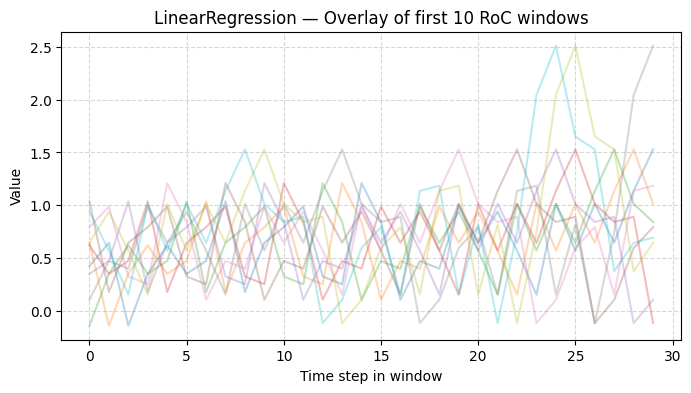

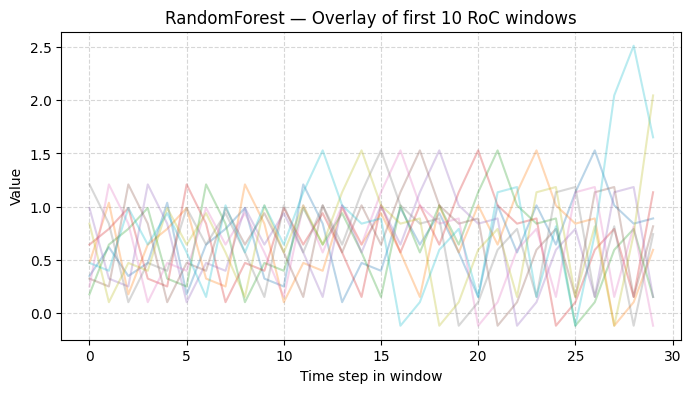

In [ ]:
num_to_plot = 10  # how many windows to overlay per model

for name, model in forecasters.items():
    wins = model.roc[:num_to_plot]  # wins are now the actual windows, not indices
    if not wins:
        print(f"{name}: no RoC windows to plot.")
        continue

    plt.figure(figsize=(8, 4))
    for w in wins:
        plt.plot(w, alpha=0.3)  # plot the window directly

    plt.title(f"{name} — Overlay of first {len(wins)} RoC windows")
    plt.xlabel("Time step in window")
    plt.ylabel("Value")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()